In [2]:
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import svm
import seaborn as sns 

import statsmodels.api as sm
sns.set()


from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, explained_variance_score



import reproduction
import general_code
import marie

%load_ext autoreload
%autoreload 2

# Definition of the data vizualization functions

here we aim to plot the predicted value with its confidence interval 

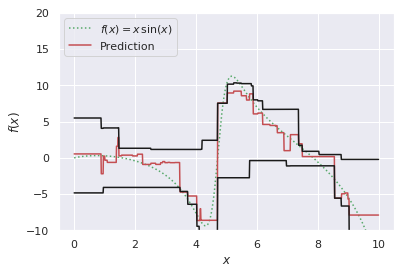

In [10]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor

np.random.seed(1)


def f(x):
    """The function to predict."""
    return x * np.cos(x)/(np.sin(x)+1.1)

#----------------------------------------------------------------------
#  First the noiseless case
X = np.atleast_2d(np.random.uniform(0, 10.0, size=100)).T
X = X.astype(np.float32)

# Observations
y = f(X).ravel()

dy = 1.5 + 1.0 * np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise
y = y.astype(np.float32)

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
xx = np.atleast_2d(np.linspace(0, 10, 1000)).T
xx = xx.astype(np.float32)

alpha = 0.95

clf = GradientBoostingRegressor(loss='quantile', alpha=alpha,
                                n_estimators=250, max_depth=3,
                                learning_rate=.1, min_samples_leaf=9,
                                min_samples_split=9)

clf.fit(X, y)

# Make the prediction on the meshed x-axis
y_upper = clf.predict(xx)

clf.set_params(alpha=1.0 - alpha)
clf.fit(X, y)

# Make the prediction on the meshed x-axis
y_lower = clf.predict(xx)

clf.set_params(loss='ls')
clf.fit(X, y)

# Make the prediction on the meshed x-axis
y_pred = clf.predict(xx)

# Plot the function, the prediction and the 90% confidence interval based on
# the MSE
fig = plt.figure()
plt.plot(xx, f(xx), 'g:', label=u'$f(x) = x\,\sin(x)$')
#plt.plot(X, y, 'b.', markersize=10, label=u'Observations')
plt.plot(xx, y_pred, 'r-', label=u'Prediction')
plt.plot(xx, y_upper, 'k-')
plt.plot(xx, y_lower, 'k-')
#plt.fill(np.concatenate([xx, xx[::-1]]),np.concatenate([y_upper, y_lower[::-1]]),alpha=.5, fc='b', ec='None', label='90% prediction interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')
plt.show()

# Loading the data

In [4]:
import run_reproduction

In [5]:
file = "../Data/result_full_factorial_pgm.csv"

In [6]:
data = run_reproduction.Data_prep_replication(file)

In [7]:
weights = run_reproduction.weights_obtain(data)

In [8]:
results = run_reproduction.regression_results(data)

In [9]:
results.head()

Median of the Massdistribution in kDa  \
                                          
0                                  31.9   
1                                  31.9   
2                                  31.9   
3                                  31.9   
4                                  31.9   

  Sigma parameter of the Massdistribution Volume fraction Rate constant  \
                                                                          
0                                   0.825             0.0        k1_bwd   
1                                   0.825             0.0        k1_fwd   
2                                   0.825             0.0        k2_bwd   
3                                   0.825             0.0        k2_fwd   
4                                   0.825             0.1        k1_bwd   

       beta                               alpha E                ...       \
   Estimate     0.025     0.975 p-value  Estimate     0.025      ...        
0 -0.014756 -0.014822 -0.014691     0.0 -0.000190 -0.000317      ...        
1  0.073132  0.070293  0.075971     0.0  0.010658  0.003545      ...        
2  0.068795  0.065675  0.071915     0.0  0.000481 -0.005600      ...        
3 -0.014756 -0.014821 -0.014690     0.0 -0.000190 -0.000317      ...        
4 -0.117351 -0.117510 -0.117192     0.0  0.001708  0.001396      ...        

   alpha ES                  alpha P                                    \
      0.975        p-value  Estimate     0.025     0.975       p-value   
0  0.000109   7.713487e-01 -0.002936 -0.002976 -0.002896  0.000000e+00   
1  0.011204   8.019231e-02  0.000256 -0.001460  0.001971  7.701728e-01   
2  0.006852   7.308795e-01  0.006592  0.004601  0.008584  9.199772e-11   
3  0.000108   7.688221e-01 -0.002936 -0.002976 -0.002896  0.000000e+00   
4  0.003771  5.107549e-100 -0.003575 -0.003673 -0.003478  0.000000e+00   

    alpha S                                    
   Estimate     0.025     0.975       p-value  
0 -0.002936 -0.002976 -0.002896  0.000000e+00  
1  0.004736  0.002871  0.006600  6.552938e-07  
2 -0.000230 -0.002004  0.001545  7.996240e-01  
3 -0.002936 -0.002976 -0.002896  0.000000e+00  
4 -0.003564 -0.003661 -0.003468  0.000000e+00  

[5 rows x 24 columns]

X = data.loc[:, data.columns != '']
X_train, X_test, y_train, y_test = train_test_split(X, y1, random_state=0, test_size=0.4)
print(X_train.shape, X_test.shape)

In [10]:
marie.regression_results(data)

Median of the Massdistribution in kDa  \
                                           
0                                   31.9   
1                                   31.9   
2                                   31.9   
3                                   31.9   
4                                   31.9   
5                                   31.9   
6                                   31.9   
7                                   31.9   
8                                   31.9   
9                                   31.9   
10                                  31.9   
11                                  31.9   
12                                  31.9   
13                                  31.9   
14                                  31.9   
15                                  31.9   
16                                  31.9   
17                                  31.9   
18                                  31.9   
19                                  31.9   
20                                  31.9   
21                                  31.9   
22                                  31.9   
23                                  31.9   
24                                  12.1   
25                                  12.1   
26                                  12.1   
27                                  12.1   
28                                  12.1   
29                                  12.1   
..                                   ...   
54                                  21.1   
55                                  21.1   
56                                  21.1   
57                                  21.1   
58                                  21.1   
59                                  21.1   
60                                  21.1   
61                                  21.1   
62                                  21.1   
63                                  21.1   
64                                  36.8   
65                                  36.8   
66                                  36.8   
67                                  36.8   
68                                  36.8   
69                                  36.8   
70                                  36.8   
71                                  36.8   
72                                  36.8   
73                                  36.8   
74                                  36.8   
75                                  36.8   
76                                  36.8   
77                                  36.8   
78                                  36.8   
79                                  36.8   
80                                  36.8   
81                                  36.8   
82                                  36.8   
83                                  36.8   

   Sigma parameter of the Massdistribution Volume fraction Rate constant  \
                                                                           
0                                    0.825             0.0        k1_bwd   
1                                    0.825             0.0        k1_fwd   
2                                    0.825             0.0        k2_bwd   
3                                    0.825             0.0        k2_fwd   
4                                    0.825             0.1        k1_bwd   
5                                    0.825             0.1        k1_fwd   
6                                    0.825             0.1        k2_bwd   
7                                    0.825             0.1        k2_fwd   
8                                    0.825             0.2        k1_bwd   
9                                    0.825             0.2        k1_fwd   
10                                   0.825             0.2        k2_bwd   
11                                   0.825             0.2        k2_fwd   
12                                   0.825             0.3        k1_bwd   
13                                   0.825             0.3        k1_fwd   
14            

In [11]:
#we look for a crowding condition of 10%
test = data[(data['volume_fraction']==0.1)]

test = test[(test['sigma_mass'] == 0.825)]
test = test[(test['mu_mass']== 31.9)]
Weights = charles.weights_obtain(test)

In [12]:
Weights.head()

,log_k1_bwd,log_k1_fwd,log_k2_bwd,log_k2_fwd
32,239.458272,5.794849,18.531392,239.432029
85,202.857544,5.794849,6.240296,202.889652
92,169.469705,10.725398,18.531392,169.378527
93,202.857544,10.725398,18.531392,202.889652
162,202.857544,10.725398,18.531392,202.889652


## Notation

y1 = log_k1_bwd

y2 = log_k1_fwd

y3 = log_k2_bwd

y4 = log_k2_fwd

In [13]:
# build the model matrix
X = test[['E','ES','P','S']]
X = sm.add_constant(X)

In [14]:
X.head()

,const,E,ES,P,S
32,1.0,0.587787,-1.609438,-1.386294,-1.386294
85,1.0,-0.916291,0.470004,1.098612,-1.098614
92,1.0,0.587787,-1.609438,1.098612,0.693147
93,1.0,0.182322,-0.223144,1.098612,1.386294
162,1.0,-0.223144,0.182322,1.609438,0.000000


In [15]:
model_y1 = sm.WLS(test['log_k1_bwd'],X, weights=Weights.log_k1_bwd).fit()
model_y2 = sm.WLS(test['log_k1_fwd'],X, weights=Weights.log_k1_fwd).fit()
model_y3 = sm.WLS(test['log_k2_bwd'],X, weights=Weights.log_k2_bwd).fit()
model_y4 = sm.WLS(test['log_k2_fwd'],X, weights=Weights.log_k2_fwd).fit()

In [16]:
print(model_y1.summary())
print(model_y2.summary())
print(model_y3.summary())
print(model_y4.summary())

                            WLS Regression Results                            
Dep. Variable:             log_k1_bwd   R-squared:                       0.610
Model:                            WLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     2804.
Date:                Tue, 04 Dec 2018   Prob (F-statistic):               0.00
Time:                        15:16:30   Log-Likelihood:                 27985.
No. Observations:                7178   AIC:                        -5.596e+04
Df Residuals:                    7173   BIC:                        -5.592e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1174   8.12e-05  -1445.573      0.0

In [36]:
print(model_y1.rsquared_adj)

0.6097187350183837


In [18]:
models = [model_y1,model_y2,model_y3,model_y4]
for m in models:
    print(m.mse_total)

0.012773170549893496
0.12348772813759348
0.11275891765965092
0.012772664122614824


In [79]:
R,M = charles.obtain_measure_goodness_of_fit_reproduction()

In [90]:
# name = 'log_k2_fwd'
print(R[name])
print(" ")
print(M[name])


  log_k2_fwd
0   0.609924
1   0.456643
2   0.420102
3   0.385573
4   0.289413
 
  log_k2_fwd
0   0.012773
1   0.015122
2   0.020826
3   0.028373
4   0.035205


In [86]:
M

,volume fraction,log_k1_bwd,log_k1_fwd,log_k2_bwd,log_k2_fwd
0,0.1,0.012773,0.123488,0.112759,0.012773
1,0.2,0.015123,0.119133,0.116126,0.015122
2,0.3,0.020830,0.112683,0.113419,0.020826
3,0.4,0.028364,0.129048,0.127563,0.028373
4,0.5,0.035219,0.099133,0.098250,0.035205


In [85]:
R

,volume fraction,log_k1_bwd,log_k1_fwd,log_k2_bwd,log_k2_fwd
0,0.1,0.609936,0.003768,0.002701,0.609924
1,0.2,0.456869,0.003826,0.003897,0.456643
2,0.3,0.420213,0.006756,0.006913,0.420102
3,0.4,0.385375,0.005941,0.007170,0.385573
4,0.5,0.289455,0.003020,0.002676,0.289413


In [19]:
file_results = '../results/reproduction.csv'

In [20]:
results = pd.read_csv(file_results)

In [21]:
results

,Unnamed: 0,Median of the Massdistribution in kDa,Sigma parameter of the Massdistribution,Volume fraction,Rate constant,beta,beta.1,beta.2,beta.3,alpha E,...,alpha ES.2,alpha ES.3,alpha P,alpha P.1,alpha P.2,alpha P.3,alpha S,alpha S.1,alpha S.2,alpha S.3
0,NaN,NaN,NaN,NaN,NaN,Estimate,0.025000,0.975000,p-value,Estimate,...,0.975000,p-value,Estimate,0.025000,0.975000,p-value,Estimate,0.025000,0.975000,p-value
1,0.0,31.9,0.825,0.0,k1_bwd,-0.014756171210216714,-0.014822,-0.014691,0.0,-0.00018996584195793604,...,0.000109,0.7713486948317397,-0.0029360902263253575,-0.002976,-0.002896,0.0,-0.002936232106218257,-0.002976,-0.002896,0.0
2,1.0,31.9,0.825,0.0,k1_fwd,0.07313186029193425,0.070293,0.075971,0.0,0.010657803520008065,...,0.011204,0.08019231414507644,0.00025562547653320324,-0.001460,0.001971,0.7701728035814398,0.004735628026615096,0.002871,0.006600,6.552938255951277e-07
3,2.0,31.9,0.825,0.0,k2_bwd,0.06879489446747342,0.065675,0.071915,0.0,0.0004810697173589064,...,0.006852,0.7308794937759122,0.0065921456310595854,0.004601,0.008584,9.199771858057634e-11,-0.0002297661099860549,-0.002004,0.001545,0.7996239828674113
4,3.0,31.9,0.825,0.0,k2_fwd,-0.01475573622233773,-0.014821,-0.014690,0.0,-0.00018984095668022667,...,0.000108,0.7688220863238069,-0.002936230419786162,-0.002976,-0.002896,0.0,-0.0029363680354143815,-0.002976,-0.002896,0.0
5,4.0,31.9,0.825,0.1,k1_bwd,-0.11735067173974212,-0.117510,-0.117192,0.0,0.0017081193975881557,...,0.003771,5.107549049430483e-100,-0.0035750086778206665,-0.003673,-0.003478,0.0,-0.0035643976661084947,-0.003661,-0.003468,0.0
6,5.0,31.9,0.825,0.1,k1_fwd,0.26138249105802336,0.257743,0.265022,0.0,0.01979283936881296,...,0.021410,0.001022241315751523,0.0025114206446139094,0.000159,0.004863,0.03637076265872756,-0.0001133873226313053,-0.002435,0.002208,0.9237206003240055
7,6.0,31.9,0.825,0.1,k2_bwd,0.2543764245835605,0.250997,0.257756,0.0,0.0039282311125042775,...,0.003179,0.3585310487114792,0.0027550521965083656,0.000699,0.004811,0.008628375557121233,0.00011628674659887599,-0.001807,0.002039,0.9056472204117453
8,7.0,31.9,0.825,0.1,k2_fwd,-0.11734724715020078,-0.117506,-0.117188,0.0,0.0017108612667562154,...,0.003774,3.6901506070610307e-100,-0.003575233185435539,-0.003673,-0.003478,0.0,-0.0035643954943902286,-0.003661,-0.003468,0.0
9,8.0,31.9,0.825,0.2,k1_bwd,-0.2803085488761447,-0.280574,-0.280043,0.0,0.0006472950673686662,...,0.000341,0.5018659956694662,-0.004523846203125894,-0.004685,-0.004363,0.0,-0.0045257456250006566,-0.004686,-0.004365,0.0


we want to plot the evolution of the different coefficients wrt to the evolution of the volume fraction 

In [22]:
results['Median of the Massdistribution in kDa'].unique()

array([ nan, 31.9, 12.1, 21.1, 36.8])

In [23]:
data_of_interest = results[(results['Rate constant']== 'k1_bwd') & (results['Median of the Massdistribution in kDa'] < 21)]

intercept_k1_bwd = data_of_interest.beta.values.astype(np.float)
alpha_E_k1_bwd = data_of_interest['alpha E'].values.astype(np.float)
alpha_E_k1_bwd_below = data_of_interest['alpha E.1'].values.astype(np.float)
alpha_E_k1_bwd_above = data_of_interest['alpha E.2'].values.astype(np.float)

alpha_ES_k1_bwd = data_of_interest['alpha ES'].values.astype(np.float)
alpha_P_k1_bwd = data_of_interest['alpha P'].values.astype(np.float)
alpha_S_k1_bwd = data_of_interest['alpha S'].values.astype(np.float)
volume_frac = data_of_interest['Volume fraction'].values.astype(np.float)

Text(0.5,1,'for k1_bwd')

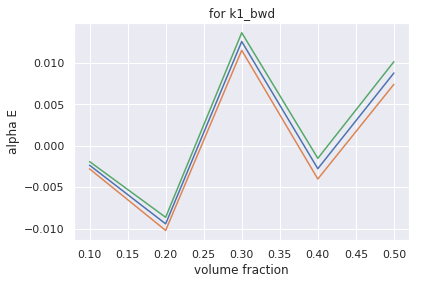

In [24]:
plt.plot(volume_frac,alpha_E_k1_bwd)
plt.plot(volume_frac,alpha_E_k1_bwd_below)
plt.plot(volume_frac,alpha_E_k1_bwd_above)
plt.xlabel("volume fraction")
plt.ylabel("alpha E")
plt.title("for k1_bwd")

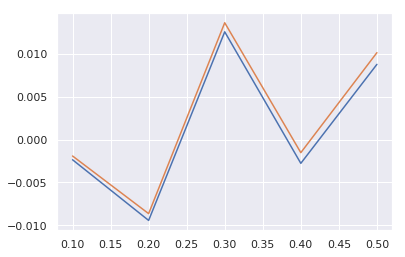

In [25]:
ax = sns.lineplot(volume_frac,alpha_E_k1_bwd)
ax = sns.lineplot(volume_frac, alpha_E_k1_bwd_above)

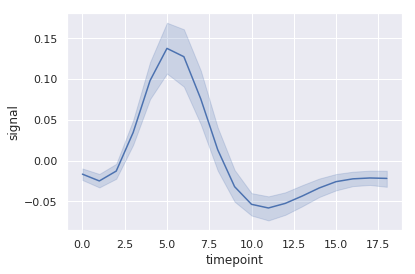

In [26]:
fmri = sns.load_dataset("fmri")
ax = sns.lineplot(x="timepoint", y="signal", data=fmri)


#  <span style="color:red"> *Garbage, don't look* </span>.

# From the paper, theory

Linear regression to estimate $\beta$ and $\alpha_j$ in the following model:

\begin{equation*}
log(\frac{k_j}{k_{j,0}}) = \beta_j + \alpha_{E,j}log(\frac{[E]}{[E]_0}) + \alpha_{ES,j}log(\frac{[ES]}{[ES]_0})  + \alpha_{P,j}log(\frac{[P]}{[P]_0})  + \alpha_{S,j}log(\frac{[S]}{[S]_0}) 
\end{equation*}

where $j\in [1_{bwd}, 1_{fwd}, 2_{bwd}, 2_{fwd}]$,

$k$ is the effective rate constant, and $k_0$ is the relative rate constant


basically the log ration of the concentration only depends on the volume fraction, the sigma mass and the mu mass: we don't need the covariate [E], [S], [ES], [P] and we can predict exactly the results

form the code of the paper

In [27]:
X = data[['E','ES','P','S']]
Y = data.log_k1_bwd

X = sm.add_constant(X)

In [28]:
model = LinearRegression()
model.fit(X,Y)
res = (Y-model.predict(X)).values

In [29]:
model2 = sm.OLS(X,Y).fit()
res2 = sm.OLS(X,Y).fit().resid

In [30]:
res2

,const,E,ES,P,S
0,0.625227,-1.539378,0.657949,0.690132,-0.002723
1,0.624011,0.658074,-1.539047,1.095588,1.606706
2,0.873336,0.360151,-0.487112,-1.099633,-0.694067
3,-0.295485,0.712180,-0.673758,1.375873,-1.395706
4,0.616048,0.659562,-1.537557,-0.003089,1.095823
5,-0.345147,0.839247,-1.357608,-1.397115,-0.702920
6,0.621572,-0.152401,0.253169,-0.003044,0.690398
7,-0.053810,-0.719293,0.667292,-1.617915,-0.700803
8,0.621997,0.540667,-0.845523,1.606397,0.690401
9,0.396753,0.112770,0.112936,-1.391147,-0.697530


In [31]:
import numpy as np
import statsmodels.api as sm
data = sm.datasets.longley.load()
data.exog = sm.add_constant(data.exog)
ols_resid = sm.OLS(data.endog, data.exog).fit().resid
res_fit = sm.OLS(ols_resid[1:], ols_resid[:-1]).fit()
rho = res_fit.params

In [32]:
ols_resid

array([ 267.34002979,  -94.01394237,   46.28716779, -410.1146219 ,
        309.71459079, -249.3112153 , -164.04895636,  -13.18035684,
         14.30477263,  455.39409458,  -17.26892708,  -39.05504249,
       -155.54997356,  -85.67130801,  341.93151399, -206.75782516])

# Computation of the residuals   

### note

We have to do this for each "group" define by a combination of values of `sigma_mass`, `mu_mass` and `volume_occupation`

following the paper process we compute regression like the following one : 


`log_k_j` = $\beta + \alpha_1$ `E` + $r_E$

and then compute an estimate of the variance: 

$\sqrt{\frac{RSS}{n-2}}$  where RSS = $|| r_E||_2^2$

In [33]:
#create dataframe to do the regression
def create_regressors(data_test,name):
    x = data_test[name].values
    X = np.c_[np.ones(len(x)), x]
    return X

In [34]:
#do the regression and return the model fitted
def regression(X,y):
    reg = LinearRegression()
    reg.fit(X,y)
    
    y_hat = reg.predict(X)
    coeffs = reg.coef_
    residuals = (y-y_hat).values
    return coeffs,y_hat,residuals

In [35]:
mus = data.mu_mass.unique()
sigmas = data.sigma_mass.unique()
volumes = [0.1,0.2,0.3,0.4,0.5]

names = ["E","ES","P","S"]

AttributeError: 'Dataset' object has no attribute 'mu_mass'

In [ ]:
def Regressors(data):
    '''
    return a vector containing the design matrix for the regression of the log efficient rate ratio against 
    E,ES,P,S in that order
    '''
    X_total = []
    for name in names:
        X_total.append(create_regressors(data,name))
    return X_total

In [ ]:
#combination done into the paper
combinations = [[31.9,0.825],[12.1,0],[21.1,0],[36.8,0]]

we do the regression oonly for `log_k1_backward`

In [ ]:
results = []

for volume in volumes:
    for comb in combinations:
        mu = comb[0]
        sigma =comb[1]
        #take data wth corresponding values in mu, sigma and volume fraction
        data_tested = data_trans[(data_trans['volume_fraction']== volume) & (data_trans['sigma_mass'] == sigma) 
                                         & (data_trans['mu_mass'] == mu)]
        
        
        #build regression matrices
        X_total = Regressors(data_tested)
        y = data_tested.log_k1_bwd
        
        #storage for the model
        #do the regression for each individual regressor (E,ES,P,S)
        for i,X in enumerate(X_total):
            c,y_,r = regression(X,y)
            results.append([volume,mu,sigma,names[i],c,y_,r])


In [ ]:
results =  pd.DataFrame(results)
results.columns = ["volume fraction","mu mass","sigma mass","regressor","coefficients","fitted values","residuals"]
results.head()

Now for each of the possible model, we compute the estimated variance of the residuals 

In [ ]:
def estimate_variance(residuals):
    '''
    compute an estimate of the variance of the residuals of the residuals of a simple model with intercept + one covariate
    '''
    
    return np.sqrt(residuals.T@residuals/(len(residuals)-2)) 

In [ ]:
variances = []
for elt in results.residuals:
    variances.append(estimate_variance(elt))

results['variance'] = variances

In [ ]:
results.head()

from the paper, we now have that the variances we just computed can be used as weights in the following weighted linear regression:


\begin{equation}
log(\frac{k_j}{k_{j,0}}) = \beta_j + \frac{1}{w_{E,j}}\alpha_{E,j}log(\frac{[E]}{[E]_0}) + \frac{1}{w_{ES,j}}\alpha_{ES,j}log(\frac{[ES]}{[ES]_0})  + \frac{1}{w_{P,j}}\alpha_{P,j}log(\frac{[P]}{[P]_0})  + \frac{1}{w_{S,j}}\alpha_{S,j}log(\frac{[S]}{[S]_0}) 
\end{equation}


for example for the regression with crowding condition of  10% `volume_fraction`= 0.1, $\sigma$ = 0,825 `sigma_mass`, $\mu$ = 31,9 `mu_mass`

from the paper we obtain the follwing results: 


| rate constant | beta         | alpha E     | alpha ES             | alpha P              | alpha S               |
|---------------|--------------|-------------|----------------------|----------------------|-----------------------|
| k1_bwd        | -0,117350672 | 0,001708119 | 0,00345717778022485  | -0,00357500867782065 | -0,00356439766610846  |
| k1_fwd        | 0,261382491  | 0,019792839 | 0,0134094988545651   | 0,00251142064461377  | -0,000113387322631445 |
| k2_bwd        | 0,254376425  | 0,003928231 | -0,00280085370093718 | 0,00275505219650836  | 0,000116286746598914  |
| k2_fwd        | -0,117347247 | 0,001710861 | 0,0034597304524437   | -0,00357523318543554 | -0,00356439549439028  |

we select from the data we computed beforeonly the relevant part 

In [ ]:
interest = results[(results['volume fraction'] == 0.1) & (results['sigma mass']== 0.825) & (results['mu mass']==31.9)]
interest.head()

In [ ]:
#we now define the weights: 
weights  = interest.variance.values
[wE,wES,wP,wS]=1/weights


#we first take the subset of the data that corresponds to our case (V = 0.1, sigma = 0.825, mu = 31.9)
data_interest = data_trans[(data_trans['volume_fraction'] == 0.1) & (data_trans['sigma_mass']== 0.825) &
                           (data_trans['mu_mass']==31.9)]

#we compute our design matrix
X_interest = create_regressors(data_interest,["E",'ES','P','S'])

#we then modify with our weights in order to do the weigthed linear regression 
X_interest *= [1,wE,wES,wP,wS]

#we then do the regression for all four responses
y1 = data_interest.log_k1_bwd
y2 = data_interest.log_k1_fwd
y3 = data_interest.log_k2_bwd
y4 = data_interest.log_k2_fwd
 
Y = [y1,y2,y3,y4]

for i,y_int in enumerate(Y):
    model = LinearRegression()
    model.fit(X_interest,y_int)
    coeff = model.coef_
    print("model for y_",i,": ")
    print("coefficients for the models, beta, alpha E, alpha ES, alpha P, alpha S")
    print(coeff*[1,wE,wES,wP,wS])

#### note

here we computed approximation for all four covariates, but we only computed the weights for `log_k1_bwd`, so it is the only computation which is really valuable, but still the results are very different

In [ ]:
print(len(results.variance.unique()))
print(len(results['volume fraction'].unique()))

# Test the reproducibility

### for $log\left(\frac{k_{1,\text{forward,eff}}}{k_{1,\text{forward,relative}}}\right)$, using volume fraction  = $0.0$

In [ ]:
# select data corresponding to our case
data_test = data_trans[data_trans['volume_fraction']==0.0]

#define the y for the regression
y = data_test["log_k1_fwd"]

#define the features we will regress on
x = data_test[['E', 'ES', 'P', 'S']].values
X = X = np.c_[np.ones(len(x)), x] #add intercept

In [ ]:
def create_regressors(data_test,name):
    x = data_test[name].values
    X = np.c_[np.ones(len(x)), x]
    return X

In [ ]:
data_test.size

from the paper, we excpect to have the following result: 

$\beta = 7.31e-2$

$\alpha = [4.74e-3,1.07e-2,-,-]$ for the following features: S, E, ES, P

#### residuals computed from regression with all the features 

first we compute a regular linear regression in order to estimate the conitionnal variance of the residuals:

In [ ]:
#fit linear model
reg = LinearRegression()
X_E = create_regressors(data_test,['E','ES','P','S'])
reg.fit(X_E,y)

#get the fitted values
y_hat = reg.predict(X_E)
residuals = (y-y_hat).values

#compute the residuals

In [ ]:
plt.plot(y_hat,residuals/y)
plt.show()

In [ ]:
plt.scatter(y = y, x = data_test['E'].values)
plt.plot(data_test['E'].values, y_hat,color='red')
plt.show()

since s = RSS: 

In [ ]:
weight_estimate = np.sqrt(np.var(residuals)/(X_E.size -2))

In [ ]:
data_test_weighted = data_test.copy()
data_test_weighted['E'] =  data_trans['E']/weight_estimate
data_test_weighted['ES'] = data_trans['ES']/weight_estimate
data_test_weighted['P'] =  data_trans['P']/weight_estimate
data_test_weighted['S'] =  data_trans['S']/weight_estimate
data_test_weighted.describe()

In [ ]:
data_test_weighted

In [ ]:
reg = LinearRegression()
X = create_regressors(data_test_weighted,['E','ES','P','S'])
reg.fit(X,y)

print(reg.coef_)


#### residuals computed for each feature individually

In [ ]:
def estimate_weight(data,covariate):
    
    y = data["log_k1_bwd"]
    #regression only with a certain feature covariate
    reg = LinearRegression()
    X = create_regressors(data,covariate)
    reg.fit(X,y)

    #find the residuals
    y_hat = reg.predict(X)
    residuals = (y-y_hat).values

    #computation of the weight
    weight_estimate = np.sqrt(np.var(residuals)/(X.size -2))
    
    return weight_estimate

In [ ]:
covariates = ['E','S','ES','P']
weights = []

for name in covariates:
    weights.append(estimate_weight(data_test,name))

In [ ]:
print(weights)

we obtain the same weight for the different covariates

In [ ]:
# count the different type of volume occupation
vfraction = data['volume_fraction'].values
unique = np.unique(vfraction)

In [ ]:
Weight = []
for volume in unique:
    w = []
    data = data_trans[data_trans['volume_fraction']==volume]
    for name in covariates:
        w.append(estimate_weight(data_test,name))
    Weight.append(w)
    print(w)

In [ ]:
tab_weights2 = pd.DataFrame(Weight)

tab_weights[0].values[0]

In [ ]:
tab_weights2[0].values[0]

issue : same weight for all types of concentration

but it is still different for the different coefficient we are trying to estimate:

for y1_forward : 2.4322071957924314e-18

for y1_backward: 1.529293643074293e-18

let's try to do a weigthed regression with these weights:

In [ ]:
reg = LinearRegression()

data_test_weighted = data_trans.copy()
data_test_weighted['E'] =  data_trans['E']/1.529293643074293e-18
data_test_weighted['ES'] = data_trans['ES']/1.529293643074293e-18
data_test_weighted['P'] =  data_trans['P']/1.529293643074293e-18
data_test_weighted['S'] =  data_trans['S']/1.529293643074293e-18


D = data_test_weighted[data_test_weighted["volume_fraction"]==0.2]
X = create_regressors(D,covariates)
y = D["log_k1_bwd"]

reg.fit(X,y)

reg.coef_

In [ ]:
reg.coef_/1.529293643074293e-18

In [ ]:
w = 1#.529293643074293e-18

mod_wls = sm.WLS(y, X, weights=1./(w))
res_wls = mod_wls.fit()
print(res_wls.summary())